<a href="https://colab.research.google.com/github/missiemccown/Creating-a-Chatbot-week3/blob/main/Copy_of_Capstone_Student_Success_Predictor_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("student-mat.csv", sep=';')

print("Shape:", df.shape)
display(df.head())


Shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
df = pd.read_csv("student-mat.csv", sep=';')
print("Raw shape:", df.shape)
display(df.head())


Raw shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


=== Logistic Regression (Baseline) ===
Accuracy : 0.664
Precision: 0.727
Recall   : 0.800
F1 Score : 0.762
ROC-AUC  : 0.586

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.38      0.43        39
           1       0.73      0.80      0.76        80

    accuracy                           0.66       119
   macro avg       0.61      0.59      0.60       119
weighted avg       0.65      0.66      0.65       119



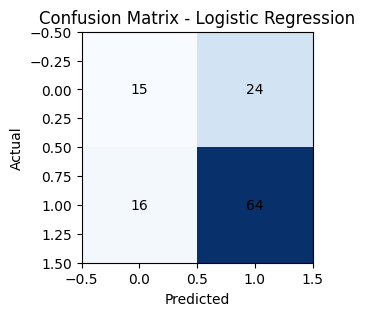

In [ ]:
# ==========================
# BASELINE MODEL (EARLY WARNING)
# ==========================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import numpy as np

# Create a binary target: pass = 1 if G3 >= 10 else 0
df['pass'] = (df['G3'] >= 10).astype(int)

# Drop G1 and G2 (avoid leakage)
X = df.drop(columns=['G1','G2','G3','pass'])
y = df['pass']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numeric features for Logistic Regression
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:,1]

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("=== Logistic Regression (Baseline) ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"ROC-AUC  : {roc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i,j), val in np.ndenumerate(cm):
    plt.text(j,i,val,ha='center',va='center')
plt.show()


In [ ]:
# ==========================
# Student Success Predictor - Model Optimization
# ==========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import shap

# Helper to summarize metrics
def summarize_metrics(y_true, y_pred, y_proba, label="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    print(f"\n=== {label} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1 Score : {f1:.3f}")
    print(f"ROC-AUC  : {roc:.3f}")
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {
        "model": label,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    }


In [ ]:
# ==========================
# Load data and build EARLY-WARNING feature set
# ==========================

# Assumes student-mat.csv is already uploaded in Colab
df = pd.read_csv("student-mat.csv", sep=';')
print("Raw shape:", df.shape)
display(df.head())

# Create binary target: pass = 1 if G3 >= 10, else 0
df['pass'] = (df['G3'] >= 10).astype(int)

# Early-warning: drop G1, G2, G3 to avoid leakage
X = df.drop(columns=['G1', 'G2', 'G3', 'pass'])
y = df['pass']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train/test split (same as baseline report)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


FileNotFoundError: [Errno 2] No such file or directory: 'student-mat.csv'

In [ ]:
# ==========================
# Baseline Logistic Regression
# ==========================

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr_baseline = LogisticRegression(max_iter=500)
lr_baseline.fit(X_train_scaled, y_train)

y_proba_lr_base = lr_baseline.predict_proba(X_test_scaled)[:, 1]
y_pred_lr_base  = (y_proba_lr_base >= 0.5).astype(int)

baseline_lr_metrics = summarize_metrics(
    y_test, y_pred_lr_base, y_proba_lr_base, label="Baseline Logistic Regression"
)


NameError: name 'X_train' is not defined

In [ ]:
# ==========================
# Load data and build EARLY-WARNING feature set
# ==========================

# Assumes student-mat.csv is already uploaded in Colab
df = pd.read_csv("student-mat.csv", sep=';')
print("Raw shape:", df.shape)
display(df.head())

# Create binary target: pass = 1 if G3 >= 10, else 0
df['pass'] = (df['G3'] >= 10).astype(int)

# Early-warning: drop G1, G2, G3 to avoid leakage
X = df.drop(columns=['G1', 'G2', 'G3', 'pass'])
y = df['pass']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train/test split (same as baseline report)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


Raw shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


((276, 39), (119, 39))

In [ ]:
# ==========================
# Baseline Logistic Regression
# ==========================

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr_baseline = LogisticRegression(max_iter=500)
lr_baseline.fit(X_train_scaled, y_train)

y_proba_lr_base = lr_baseline.predict_proba(X_test_scaled)[:, 1]
y_pred_lr_base  = (y_proba_lr_base >= 0.5).astype(int)

baseline_lr_metrics = summarize_metrics(
    y_test, y_pred_lr_base, y_proba_lr_base, label="Baseline Logistic Regression"
)



=== Baseline Logistic Regression ===
Accuracy : 0.664
Precision: 0.727
Recall   : 0.800
F1 Score : 0.762
ROC-AUC  : 0.586

Classification report:
               precision    recall  f1-score   support

           0       0.48      0.38      0.43        39
           1       0.73      0.80      0.76        80

    accuracy                           0.66       119
   macro avg       0.61      0.59      0.60       119
weighted avg       0.65      0.66      0.65       119



In [ ]:
# ==========================
# Hyperparameter Tuning - Logistic Regression
# ==========================

lr_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

lr_param_grid = {
    'lr__C': [0.01, 0.1, 1.0, 10.0],
    'lr__class_weight': [None, 'balanced']
}

lr_grid = GridSearchCV(
    lr_pipeline,
    param_grid=lr_param_grid,
    scoring='recall',   # focus on catching at-risk students
    cv=5,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

print("Best LR params:", lr_grid.best_params_)
print("Best CV Recall:", lr_grid.best_score_)

best_lr = lr_grid.best_estimator_
y_proba_lr_opt = best_lr.predict_proba(X_test)[:, 1]
y_pred_lr_opt  = (y_proba_lr_opt >= 0.5).astype(int)

opt_lr_metrics = summarize_metrics(
    y_test, y_pred_lr_opt, y_proba_lr_opt, label="Optimized Logistic Regression"
)


Best LR params: {'lr__C': 0.01, 'lr__class_weight': None}
Best CV Recall: 0.9675675675675677

=== Optimized Logistic Regression ===
Accuracy : 0.681
Precision: 0.691
Recall   : 0.950
F1 Score : 0.800
ROC-AUC  : 0.658

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.13      0.21        39
           1       0.69      0.95      0.80        80

    accuracy                           0.68       119
   macro avg       0.62      0.54      0.50       119
weighted avg       0.65      0.68      0.61       119



In [ ]:
# ==========================
# Hyperparameter Tuning - Random Forest
# ==========================

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    scoring='recall',   # same priority: recall
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best CV Recall:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_
y_proba_rf_opt = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf_opt  = (y_proba_rf_opt >= 0.5).astype(int)

opt_rf_metrics = summarize_metrics(
    y_test, y_pred_rf_opt, y_proba_rf_opt, label="Optimized Random Forest"
)


Best RF params: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 500}
Best CV Recall: 0.9621621621621621

=== Optimized Random Forest ===
Accuracy : 0.689
Precision: 0.713
Recall   : 0.900
F1 Score : 0.796
ROC-AUC  : 0.636

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.26      0.35        39
           1       0.71      0.90      0.80        80

    accuracy                           0.69       119
   macro avg       0.63      0.58      0.57       119
weighted avg       0.66      0.69      0.65       119



In [ ]:
# ==========================
# Feature Engineering - High Absences Flag
# ==========================

df_fe = df.copy()

# Create a binary feature for high absences (above or equal to median)
median_abs = df_fe['absences'].median()
df_fe['high_absences'] = (df_fe['absences'] >= median_abs).astype(int)

X_fe = df_fe.drop(columns=['G1', 'G2', 'G3', 'pass'])
y_fe = df_fe['pass']

X_fe = pd.get_dummies(X_fe, drop_first=True)

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_fe, y_fe, test_size=0.3, random_state=42, stratify=y_fe
)

fe_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

fe_pipeline.fit(Xf_train, yf_train)
y_proba_fe = fe_pipeline.predict_proba(Xf_test)[:, 1]
y_pred_fe  = (y_proba_fe >= 0.5).astype(int)

fe_metrics = summarize_metrics(
    yf_test, y_pred_fe, y_proba_fe, label="LR + High Absences Feature"
)



=== LR + High Absences Feature ===
Accuracy : 0.664
Precision: 0.727
Recall   : 0.800
F1 Score : 0.762
ROC-AUC  : 0.589

Classification report:
               precision    recall  f1-score   support

           0       0.48      0.38      0.43        39
           1       0.73      0.80      0.76        80

    accuracy                           0.66       119
   macro avg       0.61      0.59      0.60       119
weighted avg       0.65      0.66      0.65       119



In [ ]:
# ==========================
# SHAP Explainability - Optimized Random Forest
# ==========================

shap.initjs()

# Use a small sample of X_train for speed
sample_X = X_train.sample(100, random_state=42)

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(sample_X)

# Global feature importance plot
shap.summary_plot(shap_values[1], sample_X, show=True)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
# ==========================
# Hyperparameter Tuning - Random Forest (clean version)
# ==========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best CV Recall:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_


Best RF params: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 500}
Best CV Recall: 0.9621621621621621


SHAP values shape: (100, 39, 2)
Sample_X shape   : (100, 39)


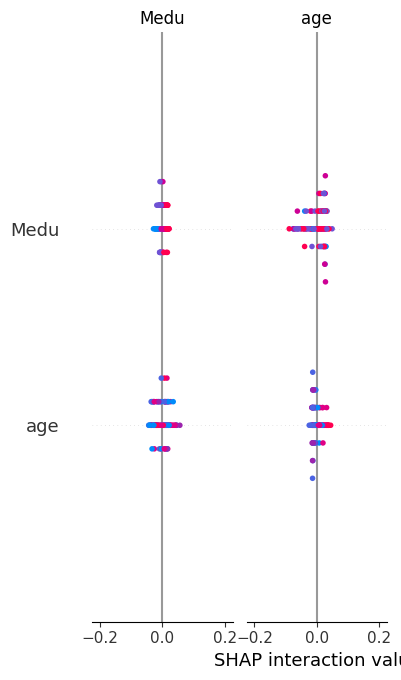

In [ ]:
# ==========================
# SHAP Explainability - Optimized Random Forest
# ==========================

import shap

shap.initjs()

# Use the SAME X_train that best_rf was trained on
sample_X = X_train.sample(100, random_state=42)

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(sample_X)

# shap_values can be a list (for classifiers) or array, handle both cases
if isinstance(shap_values, list):
    sv = shap_values[1]   # class 1 (pass=1) explanations
else:
    sv = shap_values      # already an array

print("SHAP values shape:", sv.shape)
print("Sample_X shape   :", sample_X.shape)

# Global feature importance plot
shap.summary_plot(sv, sample_X, show=True)


In [ ]:
# ==========================
# Collect all metrics in one table
# ==========================

results = []

# These dicts come from summarize_metrics() earlier
# Make sure the variable names match what you used:
#   baseline_lr_metrics, opt_lr_metrics, opt_rf_metrics, fe_metrics

results.append(baseline_lr_metrics)
results.append(opt_lr_metrics)
results.append(opt_rf_metrics)
results.append(fe_metrics)

results_df = pd.DataFrame(results)
results_df


,model,accuracy,precision,recall,f1,roc_auc
0,Baseline Logistic Regression,0.663866,0.727273,0.80,0.761905,0.585577
1,Optimized Logistic Regression,0.680672,0.690909,0.95,0.800000,0.657692
2,Optimized Random Forest,0.689076,0.712871,0.90,0.795580,0.635897
3,LR + High Absences Feature,0.663866,0.727273,0.80,0.761905,0.589103


from matplotlib import pyplot as plt
results_df['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='f1', y='roc_auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='accuracy', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='precision', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='recall', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='f1', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
results_df.to_csv("model_results_summary.csv", index=False)
print("Saved model_results_summary.csv")


Saved model_results_summary.csv


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("student-mat.csv", sep=';')

print("Shape:", df.shape)
df.head()


Shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,"GP;""F"";18;""U"";""GT3"";""A"";4;4;""at_home"";""teacher...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"GP;""F"";17;""U"";""GT3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"GP;""F"";15;""U"";""LE3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"GP;""F"";15;""U"";""GT3"";""T"";4;2;""health"";""services...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"GP;""F"";16;""U"";""GT3"";""T"";3;3;""other"";""other"";""h...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv("student-mat.csv", sep=';', encoding='latin1', engine='python')
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,"GP;""F"";18;""U"";""GT3"";""A"";4;4;""at_home"";""teacher...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"GP;""F"";17;""U"";""GT3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"GP;""F"";15;""U"";""LE3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"GP;""F"";15;""U"";""GT3"";""T"";4;2;""health"";""services...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"GP;""F"";16;""U"";""GT3"";""T"";3;3;""other"";""other"";""h...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv("student-mat.csv", sep=';', quotechar='"', engine='python')
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,"GP;""F"";18;""U"";""GT3"";""A"";4;4;""at_home"";""teacher...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"GP;""F"";17;""U"";""GT3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"GP;""F"";15;""U"";""LE3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"GP;""F"";15;""U"";""GT3"";""T"";4;2;""health"";""services...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"GP;""F"";16;""U"";""GT3"";""T"";3;3;""other"";""other"";""h...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv("student-mat.csv", sep=';', quoting=3, engine='python')
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,"""GP","""""F""""",18,"""""U""""","""""GT3""""","""""A""""",4,4,"""""at_home""""","""""teacher""""",...,4,3,4,1,1,3,6,"""""5""""","""""6""""","6"""
1,"""GP","""""F""""",17,"""""U""""","""""GT3""""","""""T""""",1,1,"""""at_home""""","""""other""""",...,5,3,3,1,1,3,4,"""""5""""","""""5""""","6"""
2,"""GP","""""F""""",15,"""""U""""","""""LE3""""","""""T""""",1,1,"""""at_home""""","""""other""""",...,4,3,2,2,3,3,10,"""""7""""","""""8""""","10"""
3,"""GP","""""F""""",15,"""""U""""","""""GT3""""","""""T""""",4,2,"""""health""""","""""services""""",...,3,2,2,1,1,5,2,"""""15""""","""""14""""","15"""
4,"""GP","""""F""""",16,"""""U""""","""""GT3""""","""""T""""",3,3,"""""other""""","""""other""""",...,4,3,2,1,2,5,4,"""""6""""","""""10""""","10"""


In [ ]:
import pandas as pd

df = pd.read_csv("student-mat.csv", sep=';', encoding='latin1', engine='python')
print(df.shape)
df.head()


(395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,"GP;""F"";18;""U"";""GT3"";""A"";4;4;""at_home"";""teacher...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"GP;""F"";17;""U"";""GT3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"GP;""F"";15;""U"";""LE3"";""T"";1;1;""at_home"";""other"";...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"GP;""F"";15;""U"";""GT3"";""T"";4;2;""health"";""services...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"GP;""F"";16;""U"";""GT3"";""T"";3;3;""other"";""other"";""h...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv("student-mat.csv", sep=';', quoting=3, engine='python')
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,"""GP","""""F""""",18,"""""U""""","""""GT3""""","""""A""""",4,4,"""""at_home""""","""""teacher""""",...,4,3,4,1,1,3,6,"""""5""""","""""6""""","6"""
1,"""GP","""""F""""",17,"""""U""""","""""GT3""""","""""T""""",1,1,"""""at_home""""","""""other""""",...,5,3,3,1,1,3,4,"""""5""""","""""5""""","6"""
2,"""GP","""""F""""",15,"""""U""""","""""LE3""""","""""T""""",1,1,"""""at_home""""","""""other""""",...,4,3,2,2,3,3,10,"""""7""""","""""8""""","10"""
3,"""GP","""""F""""",15,"""""U""""","""""GT3""""","""""T""""",4,2,"""""health""""","""""services""""",...,3,2,2,1,1,5,2,"""""15""""","""""14""""","15"""
4,"""GP","""""F""""",16,"""""U""""","""""GT3""""","""""T""""",3,3,"""""other""""","""""other""""",...,4,3,2,1,2,5,4,"""""6""""","""""10""""","10"""


In [ ]:
# Remove extra double quotes from every string column
df = df.applymap(lambda x: x.replace('"', '') if isinstance(x, str) else x)

# Show cleaned data
print(df.shape)
df.head()


(395, 33)


/tmp/ipython-input-2286570456.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('"', '') if isinstance(x, str) else x)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
# Convert numeric fields to integers where possible
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
                'absences', 'G1', 'G2', 'G3']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
# Create target variable
df['pass'] = (df['G3'] >= 10).astype(int)

# Drop leakage features (early warning)
X = df.drop(columns=['G1', 'G2', 'G3', 'pass'])
y = df['pass']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((276, 39), (119, 39))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Pipeline: scaler + logistic regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Hyperparameter grid (we optimize for recall)
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1.0, 10.0],
    'lr__class_weight': [None, 'balanced']
}

lr_grid = GridSearchCV(
    lr_pipeline,
    param_grid=lr_param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

print("Best LR params:", lr_grid.best_params_)

# This is your optimized model
best_lr = lr_grid.best_estimator_


Best LR params: {'lr__C': 0.01, 'lr__class_weight': None}


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_lr = cross_validate(
    best_lr,
    X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

def summarize_cv_results(cv_results, label):
    print(f"\n=== Cross-Validation ({label}) ===")
    for metric in scoring.keys():
        values = cv_results[f'test_{metric}']
        print(f"{metric:9s}: {values.mean():.3f} ± {values.std():.3f}")

summarize_cv_results(cv_lr, "Optimized Logistic Regression")



=== Cross-Validation (Optimized Logistic Regression) ===
accuracy : 0.681 ± 0.038
precision: 0.690 ± 0.020
recall   : 0.951 ± 0.041
f1       : 0.800 ± 0.025
roc_auc  : 0.697 ± 0.045


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions on test set
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (Optimized Logistic Regression):")
print(cm)
print(f"\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


Confusion Matrix (Optimized Logistic Regression):
[[ 5 34]
 [ 4 76]]

TN: 5, FP: 34, FN: 4, TP: 76


In [ ]:
# Attach predictions to test data
test_results = X_test.copy()
test_results['y_true'] = y_test.values
test_results['y_pred'] = y_pred_lr
test_results['proba'] = y_proba_lr

false_positives = test_results[(test_results['y_true'] == 0) & (test_results['y_pred'] == 1)]
false_negatives = test_results[(test_results['y_true'] == 1) & (test_results['y_pred'] == 0)]

print("\nFalse positives:", false_positives.shape[0])
print("False negatives:", false_negatives.shape[0])



False positives: 34
False negatives: 4


In [ ]:
orig_cols = ['failures', 'absences', 'studytime']
orig_test = df.loc[X_test.index, orig_cols].copy()

error_analysis = pd.concat([orig_test, test_results[['y_true','y_pred','proba']]], axis=1)

print("\nSummary for FALSE NEGATIVES (missed at-risk students):")
display(error_analysis[(error_analysis['y_true']==1) & (error_analysis['y_pred']==0)].describe())

print("\nSummary for FALSE POSITIVES (flagged but passed):")
display(error_analysis[(error_analysis['y_true']==0) & (error_analysis['y_pred']==1)].describe())



Summary for FALSE NEGATIVES (missed at-risk students):


,failures,absences,studytime,y_true,y_pred,proba
count,4.000000,4.000000,4.000000,4.0,4.0,4.000000
mean,2.250000,7.500000,2.250000,1.0,0.0,0.418126
std,0.957427,5.507571,0.957427,0.0,0.0,0.081753
min,1.000000,2.000000,1.000000,1.0,0.0,0.308085
25%,1.750000,3.500000,1.750000,1.0,0.0,0.380492
50%,2.500000,7.000000,2.500000,1.0,0.0,0.438259
75%,3.000000,11.000000,3.000000,1.0,0.0,0.475894
max,3.000000,14.000000,3.000000,1.0,0.0,0.487903



Summary for FALSE POSITIVES (flagged but passed):


,failures,absences,studytime,y_true,y_pred,proba
count,34.000000,34.000000,34.000000,34.0,34.0,34.000000
mean,0.294118,7.000000,1.911765,0.0,1.0,0.668311
std,0.578892,10.568679,0.753483,0.0,0.0,0.074251
min,0.000000,0.000000,1.000000,0.0,1.0,0.502688
25%,0.000000,0.000000,1.250000,0.0,1.0,0.628436
50%,0.000000,4.000000,2.000000,0.0,1.0,0.680489
75%,0.000000,9.750000,2.000000,0.0,1.0,0.718541
max,2.000000,56.000000,4.000000,0.0,1.0,0.815971


In [ ]:
thresholds = [0.4, 0.5, 0.6]
records = []

for t in thresholds:
    y_pred_t = (y_proba_lr >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec = recall_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)

    records.append({
        "threshold": t,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

pd.DataFrame(records)


,threshold,accuracy,precision,recall,f1
0,0.4,0.680672,0.681034,0.9875,0.806122
1,0.5,0.680672,0.690909,0.9500,0.800000
2,0.6,0.663866,0.712766,0.8375,0.770115
